# Implementación de Actor - Critic; algoritmo On policy

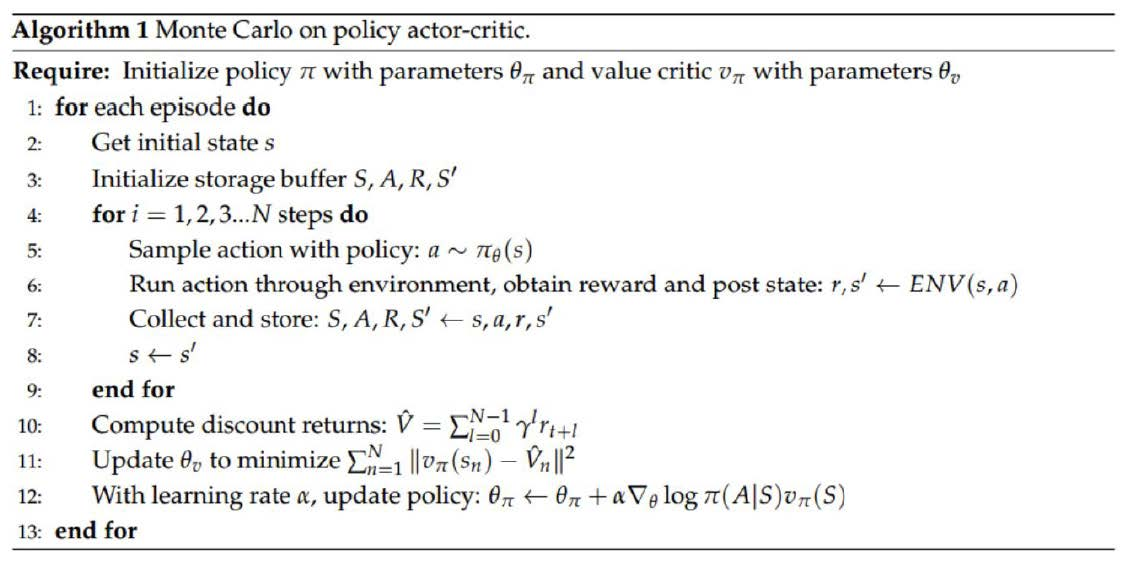

In [1]:
from IPython import display
display.Image("../img/mc-ac.jpg", width = 800, height = 400)

In [2]:
import numpy as np 
import pandas as pd

import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F 

from torch.distributions import Categorical 
from torch.autograd import Variable

import gymnasium as gym

# Explorando el env Lunar Lander

In [3]:
env = gym.make(
    "LunarLander-v2",
    continuous = False,
    gravity = -10.0,
    enable_wind= False,
    wind_power = 15.0,
    turbulence_power = 1.5,
    )


np.random.seed(42)
torch.random.seed = 42

env.reset()

print(f'El espacio de obervaciones para el Lunar lander es de: {env.observation_space.shape[0]}')
print(f'Espacio de acciones para el Lunar Lander: {env.action_space.n}')
print('\n')

state = env.reset()
print(state[0])
print('\n')

next_state, reward, done, truncated, _ = env.step(action=env.action_space.sample())
print(next_state)
print(reward)
print(done)
print(truncated)
print(_)


El espacio de obervaciones para el Lunar lander es de: 8
Espacio de acciones para el Lunar Lander: 4


[-0.00265875  1.4202796  -0.26931483  0.41597545  0.00308759  0.06100391
  0.          0.        ]


[-0.00537786  1.4290621  -0.27649117  0.39031416  0.00761447  0.09054634
  0.          0.        ]
0.36066193354923937
False
False
{}


# Definiendo el actor y el critic

In [4]:
#torch.manual_seed(42)

In [5]:
# el actor nos devuelve las probabilidades de las accines a realizar
class Actor(nn.Module): 
    def __init__(self, state_dims, action_space): 
        super(Actor, self).__init__()

        # definir la arquitectura de red
        self.fc1 = nn.Linear(in_features=state_dims, out_features=16*state_dims)
        self.fc2 = nn.Linear(in_features=state_dims*16, out_features=state_dims*32)
        self.fc3 = nn.Linear(in_features=state_dims*32, out_features=action_space)

    def forward(self, x): 
        # definimos operaciones de la red
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        action_distribution = F.softmax(self.fc3(x), dim=-1) # queremos la probabilidad de la accion

        return action_distribution

# el critc nos devuelve una estimación/prediccion de la rec-esperada
class Critic(nn.Module): 
    def __init__(self, state_dims): 
        super(Critic, self).__init__()

        self.fc1 = nn.Linear(in_features=state_dims, out_features= 8*state_dims)
        self.fc2 = nn.Linear(in_features= 8*state_dims, out_features=16*state_dims )
        self.fc3 = nn.Linear(in_features= state_dims*16, out_features=1)   

    def forward(self, x): 
        # definimos operaciones de la nn
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        value_estimation = self.fc3(x)  # solo queremos una estimación del value

        return value_estimation

# Hiper parametros

In [6]:
max_episodes = 10_000
num_max_steps_in_episode = 1000
performance_metrics = {'episode_total_rewards':[], 'episode_durations':[]}

model_name = 'LunarLander_AC.pth'
env_name = "LunarLander-v2"

# se define el enviroment
env = gym.make(
    env_name,
    continuous = False,
    gravity = -10.0,
    enable_wind= False,
    wind_power = 15.0,
    turbulence_power = 1.5,
    )

# print(torch.cuda.is_available())
print(f'El device disponible en es: ', "GPU (cuda)" if torch.cuda.is_available() else "cpu")
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

# definimos el actor y el critic
actor = Actor(state_dims= env.observation_space.shape[0], action_space= env.action_space.n)# .to(device= device)
critic = Critic(state_dims= env.observation_space.shape[0])# .to(device= device)

# hiper parametros del entrenamiento
learning_rate = 0.001 # se podria definir un learning rate diferente para cada red
batch_size = 5
gamma = 0.99 

# optimizadores
actor_optimizer = torch.optim.Adam(params=actor.parameters(), lr= learning_rate)
critic_optimizer = torch.optim.Adam(params= critic.parameters(), lr= learning_rate)


El device disponible en es:  GPU (cuda)
cuda


# Entrenamiento

In [7]:
def process_state(state): 
    state = torch.from_numpy(state).float()
    return Variable(state)

In [8]:
print(actor)  # .to(device= 'cuda')
print(critic) # .to(device= 'cuda')


Actor(
  (fc1): Linear(in_features=8, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=256, bias=True)
  (fc3): Linear(in_features=256, out_features=4, bias=True)
)
Critic(
  (fc1): Linear(in_features=8, out_features=64, bias=True)
  (fc2): Linear(in_features=64, out_features=128, bias=True)
  (fc3): Linear(in_features=128, out_features=1, bias=True)
)


In [ ]:
# reproducibilidad 
#torch.manual_seed(42)

# # se ponden los modelos en modo entrenamiento 
# actor.train()   # en evaluación habrá que poner los modelos en .eval() para que algunas cosas no se activen p.e batch normalization
# critic.train()


# los buffers de memoria, que limpiare en cada actualización de la red
action_pool = []
state_pool = []
reward_pool = []
value_pool = []


# bucle de episodios
for eps in range(max_episodes): # max_episodes
    print(f'Inicializa el epsiodio numero: {eps}')

    done = False
    state = env.reset()
    state = process_state(state=state[0]).to(device=device)
    episode_rewards = []

# bucle de trayectorias
    for t in range(num_max_steps_in_episode): #num_max_steps_in_episode

        # obtenemos la distribución de acciones y el value estimado dado el estado actual
        action_probs, estimated_value = actor(state), critic(state)   # p.e tensor([0.1, 0.3, 0.4, 0.2]), 4.55

        # calculo el logaritmo de las probabilidades de la dist de acciones
        action_log_probs = torch.log(action_probs)     # p.e log(tensor([0.1, 0.3, 0.4, 0.2]))


        # selecciono una accion mediante muestreo
        action = action_probs.multinomial(num_samples= 1) # p.e tensor([2]) la posición de la muestra seleccionada
 
        # guardo el logaritmo de la probabilidad de la accion escogida
        log_prob = action_log_probs.gather(-1, Variable(action)) # tensor(log(0.4)) el logaritmo de la probabilidad


        # realizamos un step en el entorno con la accion seleccionada
        next_state, reward, done, truncated, _ = env.step(action= action.item())

        # guardamos las recompensas del episodio
        episode_rewards.append(reward)

        # guardamos estado, accion, y value estimado
        action_pool.append(log_prob)
        state_pool.append(state)
        value_pool.append(estimated_value)

        state = process_state(next_state).to(device=device)

        if done: break
    print(f'Epsiodio {eps} finalizado con: \nDuración de {t+1}steps\nRecompensa total del episodio: {np.sum(episode_rewards)}\n')

    # descontamos las recompensas POR CADA EPISODIO
    discount_eps_reward = [0]*len(episode_rewards)
    discount_reward= 0
    for n in reversed(range(len(episode_rewards))):
        discount_reward= episode_rewards[n] + gamma*discount_reward
        discount_eps_reward[n] = discount_reward

    # AÑADIMOS LA RECOMPENSA descontada al memori buffer
    reward_pool.extend(discount_eps_reward)
    
    # guardamos las metricas de entrenamiento
    performance_metrics['episode_durations'].append(t+1)
    performance_metrics['episode_total_rewards'].append(np.sum(episode_rewards))

    # update policy cada batch size 
    if eps>0 and eps%batch_size==0: 
        print('\nActualizando la policy...')

        # normalizamos la recompensa DE todo el batch
        # batch_normalized_rewards = normalize_rewards(full_batch_rewards=reward_pool)
        reward_mean = np.mean(reward_pool)
        reward_std = np.std(reward_pool)
        norm_batch_rewards = [(reward_pool[n] - reward_mean)/(reward_std+ 1e-9) for n in range(len(reward_pool))]

        actor_total_loss =  0
        critic_total_loss = 0
        actor_optimizer.zero_grad()
        critic_optimizer.zero_grad()

        for n in range(len(reward_pool)):

            # seleccionamos la experiencia en nuestro step
            state = state_pool[n].to(device)
            action_log_prob = Variable(action_pool[n].clone().detach().to(device))
            R = norm_batch_rewards[n]
            value = value_pool[n].to(device)

            # calcular el advantage
            advantage = R - value.item()

            actor_total_loss-=  action_log_prob*advantage
            critic_total_loss+= advantage.pow(2)
        
        actor_total_loss.backward(retain_graph=True)
        actor_optimizer.step()

        critic_total_loss.backward()
        critic_optimizer.step()
    
        action_pool = []
        value_pool = []
        reward_pool = []
        state_pool = []

        print('Policy actualizada con exito!\n')

Inicializa el epsiodio numero: 0
Epsiodio 0 finalizado con: 
Duración de 71steps
Recompensa total del episodio: -111.11524320994701

Inicializa el epsiodio numero: 1
Epsiodio 1 finalizado con: 
Duración de 81steps
Recompensa total del episodio: -100.54445488853965

Inicializa el epsiodio numero: 2
Epsiodio 2 finalizado con: 
Duración de 79steps
Recompensa total del episodio: -114.35703408919113

Inicializa el epsiodio numero: 3
Epsiodio 3 finalizado con: 
Duración de 64steps
Recompensa total del episodio: -103.47471511481481

Inicializa el epsiodio numero: 4
Epsiodio 4 finalizado con: 
Duración de 80steps
Recompensa total del episodio: -214.60742302994217

Inicializa el epsiodio numero: 5
Epsiodio 5 finalizado con: 
Duración de 74steps
Recompensa total del episodio: -225.1618507600365


Actualizando la policy...
Policy actualizada con exito!

Inicializa el epsiodio numero: 6
Epsiodio 6 finalizado con: 
Duración de 119steps
Recompensa total del episodio: -242.21470120503946

Inicializa 

KeyboardInterrupt: 

In [ ]:
torch.tensor([1,2,3]).to(device).device

device(type='cuda', index=0)

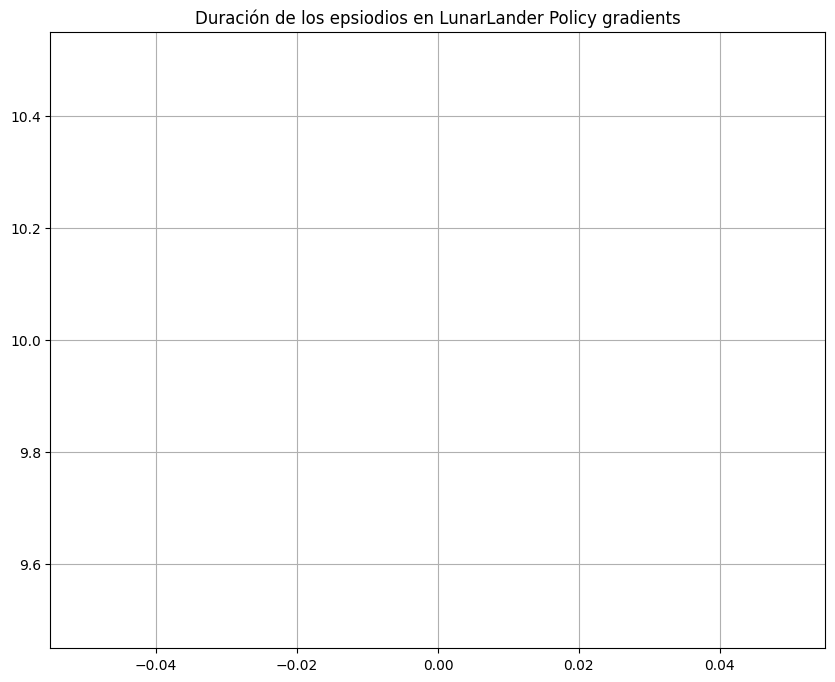

In [ ]:
import matplotlib.pyplot as plt 


plt.figure(figsize=(10, 8))
plt.plot(range(len(performance_metrics['episode_durations'])), performance_metrics['episode_durations'])
plt.title('Duración de los epsiodios en LunarLander Policy gradients')
plt.grid()
plt.show()

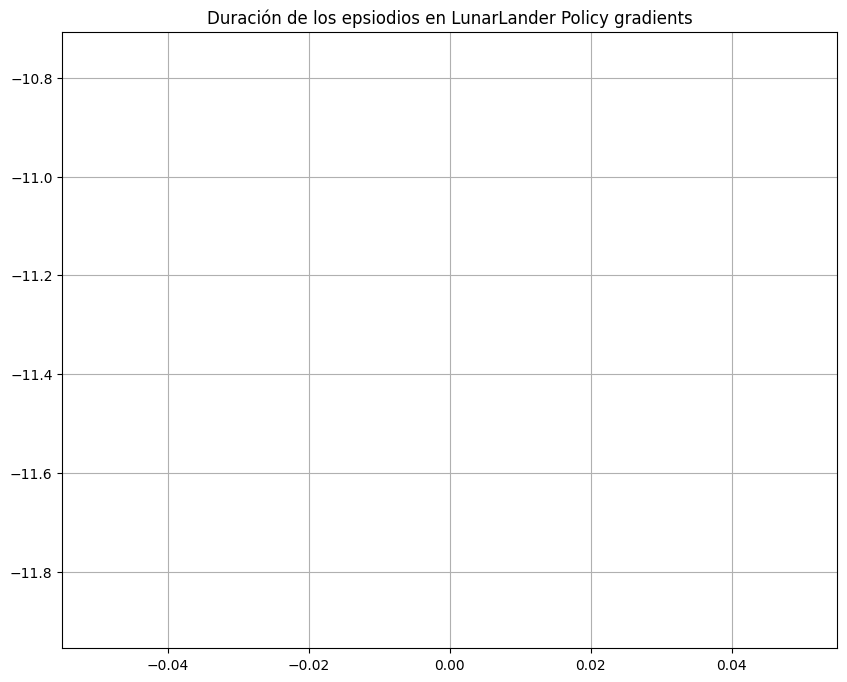

In [ ]:
import matplotlib.pyplot as plt 


plt.figure(figsize=(10, 8))
plt.plot(range(len(performance_metrics['episode_total_rewards'])), performance_metrics['episode_total_rewards'])
plt.title('Duración de los epsiodios en LunarLander Policy gradients')
plt.grid()
plt.show()